In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from quantools.backtest import *
from quantools.rubust import *

In [2]:
daily_data = pd.read_pickle("../data/stock_data.pkl.xz")
daily_data.head()

,stock_code,date,close,open,high,low,volume
0,000001.SZ,2006-01-04,148.1785,144.6392,149.3582,144.4032,7.362156e+05
1,000001.SZ,2006-01-05,149.1223,148.6504,149.8302,147.2347,7.333803e+05
2,000001.SZ,2006-01-06,151.2459,151.0099,153.3694,149.8302,1.137633e+06
3,000001.SZ,2006-01-09,150.7740,151.0099,151.9537,149.5942,5.253873e+05
4,000001.SZ,2006-01-10,148.1785,149.8302,150.0661,145.1111,1.021342e+06


In [3]:
inds = pd.read_pickle("../data/stock_industry.pkl.xz")
inds.head()

,stock_code,industry,date
0,000001.SZ,银行,2006-01-04
1,000002.SZ,房地产,2006-01-04
2,000004.SZ,医药,2006-01-04
3,000005.SZ,房地产,2006-01-04
4,000006.SZ,房地产,2006-01-04


In [4]:
def code_format(code):
    code = str(code).zfill(6)
    if code[0] == '6':
        return code+".SH"
    else:
        return code+".SZ"
    
roe = pd.read_csv("../data/roe.csv")
roe['stock_code'] = roe['stock_code'].apply(lambda x: code_format(x))
roe['rpt_date'] = roe['date'].apply(lambda x: str(x))
roe['rpt_date'] = pd.to_datetime(roe['rpt_date'])
roe = roe.drop('date', axis=1)
roe.head()

,stock_code,ROE,rpt_date
0,000001.SZ,5.13,2004-03-31
1,000001.SZ,6.72,2004-06-30
2,000001.SZ,9.31,2004-09-30
3,000001.SZ,6.19,2004-12-31
4,000001.SZ,3.19,2005-03-31


In [5]:
daily_data = daily_data[daily_data['volume']!=0].copy()

daily_data['pre_close'] = daily_data.groupby('stock_code')['close'].shift(1)
daily_data['ret'] = (daily_data['close'] - daily_data['pre_close']) / daily_data['pre_close']

daily_data['pred_rtn'] = daily_data.groupby('stock_code')['ret'].shift(-1)
daily_data.loc[(daily_data['high']==daily_data['low']) & (daily_data['close']>daily_data['pre_close']), 'pred_rtn'] = 0
daily_data['pred_rtn'] = daily_data.groupby('stock_code')['pred_rtn'].shift(-1)

In [6]:
daily_data = daily_data[['stock_code', 'date', 'pred_rtn']]

In [7]:
def match_rpt_date(date):
    """
        将日期转化为对应的报告期；
        基于：一季报最晚4/30公布，半年报8/30，三季报10/30，年报来年4/30（因此不用）
    """
    y = date.year
    m = date.month
    if m in (5, 6, 7, 8): return f"{y}0331"
    elif m in (9, 10): return f"{y}0630"
    elif m in (11, 12): return f"{y}0930"
    elif m in (1, 2, 3, 4): return f"{y-1}0930"

daily_data['rpt_date'] = daily_data['date'].apply(match_rpt_date)
daily_data['rpt_date'] = pd.to_datetime(daily_data['rpt_date'])

In [8]:
factors = pd.merge(daily_data, roe, on=['stock_code', 'rpt_date'], how='left')
factors = pd.merge(factors, inds, on=['stock_code', 'date'], how='left')

In [24]:
factors = factors[factors['date']>"2015-12-31"]

In [25]:
factors = winsorize(factors, "ROE", method="quantile", date='date', q=0.01)
factors.head()

Winsorizing the factor ROE: 100%|██████████| 6968620/6968620 [02:51<00:00, 40714.91it/s]


,stock_code,date,pred_rtn,rpt_date,ROE,industry
0,000001.SZ,2016-01-04,0.011404,2015-09-30,11.2896,银行
1,000004.SZ,2016-01-04,0.012927,2015-09-30,2.8728,医药
2,000005.SZ,2016-01-04,0.031461,2015-09-30,-4.6628,房地产
3,000006.SZ,2016-01-04,0.025896,2015-09-30,6.5103,房地产
4,000008.SZ,2016-01-04,0.013876,2015-09-30,3.4012,机械


Calculating groups: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


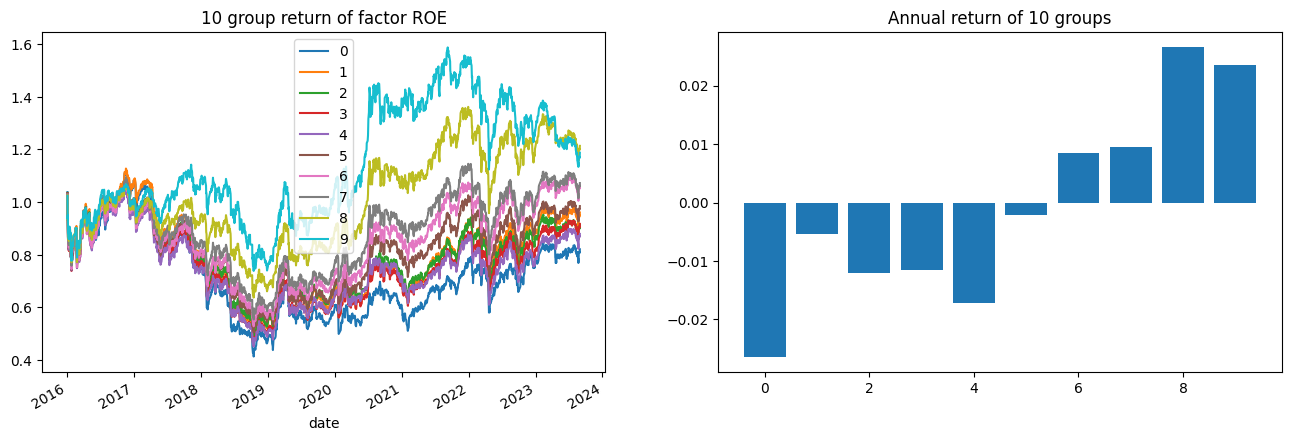

In [26]:
group_rtn, group_cum_rtn = group_return_analysis(factors, "ROE", group_num=10, plot=True, date='date', pred_rtn='pred_rtn')

In [27]:
factors = industry_neutralise(factors, "ROE", method=1, date="date", industry="industry")

使用分组标准化法进行中性化


Calculating groups: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


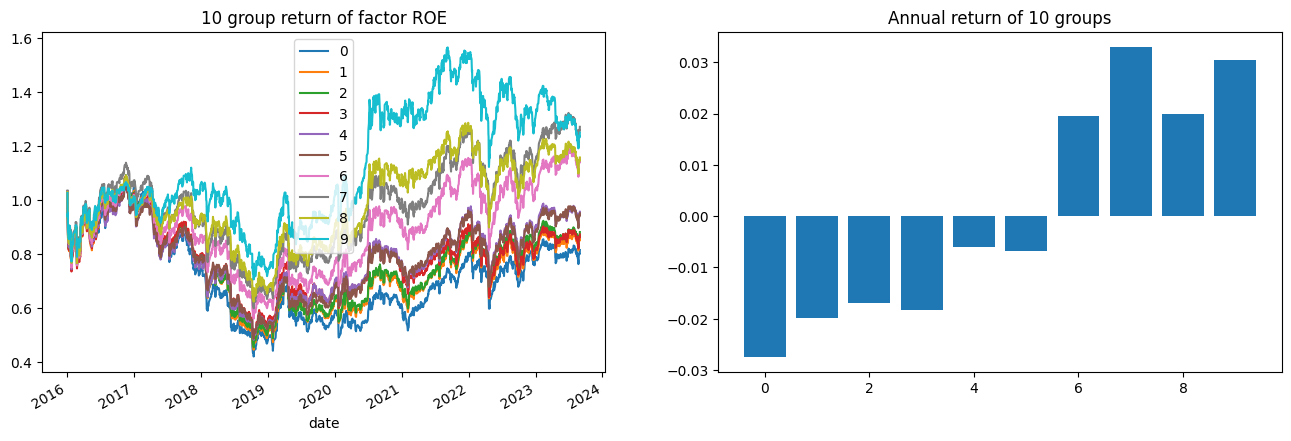

In [29]:
group_rtn_neu, group_cum_rtn_neu = group_return_analysis(factors, "ROE", group_num=10, plot=True, date='date', pred_rtn='pred_rtn')

In [ ]:
evaluate_strategy()